In [121]:
import genesis as gs
import numpy as np
import torch
from pytransform3d import (
    transformations as pt,
    rotations as pr,
    batch_rotations as pb,
    trajectories as ptr,
    plot_utils as ppu
)

import spatialmath as sm

d:\envs\pygen\Lib\site-packages\spatialmath\baseposematrix.py:611: SyntaxWarning: invalid escape sequence '\m'
  """


In [2]:
gs.init(backend=gs.cpu, seed=42)

[Genesis] [19:37:34] [INFO] ╭───────────────────────────────────────────────╮
[Genesis] [19:37:34] [INFO] │┈┉┈┉┈┉┈┉┈┉┈┉┈┉┈┉┈┉┈ Genesis ┈┉┈┉┈┉┈┉┈┉┈┉┈┉┈┉┈┉┈│
[Genesis] [19:37:34] [INFO] ╰───────────────────────────────────────────────╯
[Genesis] [19:37:36] [INFO] Running on [13th Gen Intel(R) Core(TM) i7-13800H] with backend gs.cpu. Device memory: 31.59 GB.
[Genesis] [19:37:36] [INFO] 🚀 Genesis initialized. 🔖 version: 0.2.1, 🌱 seed: 42, 📏 precision: '32', 🐛 debug: False, 🎨 theme: 'dark'.


In [4]:

scene = gs.Scene(
    show_viewer = True,
    viewer_options = gs.options.ViewerOptions(
        res           = (1280, 960),
        camera_pos    = (3.5, 0.0, 2.5),
        camera_lookat = (0.0, 0.0, 0.5),
        camera_fov    = 40,
        max_FPS       = 60,
    ),
    sim_options=gs.options.SimOptions(
        dt = 0.01,
    ),
    vis_options = gs.options.VisOptions(
        show_world_frame = True,
        world_frame_size = 1.0,
        show_link_frame  = False,
        show_cameras     = False,
        plane_reflection = True,
        ambient_light    = (0.1, 0.1, 0.1),
    ),
    renderer=gs.renderers.Rasterizer(),
)

plane = scene.add_entity(
    gs.morphs.Plane(),
)
franka = scene.add_entity(
    gs.morphs.MJCF(file='xml/franka_emika_panda/panda.xml'),
)
cube_size = (0.1, 0.07, 0.03)
cube_pos = (0.45, 0, 0.015)

cube = scene.add_entity(
    gs.morphs.Box(
        size = cube_size,
        pos  = cube_pos,
    ),
    surface=gs.surfaces.Default(
        color = (0.8, 0.1 , 0.1),   
    )
)
cube.surface.color = (0.8, 0.1 , 0.1)

cylinder_pos = (0.7, -0.2, 0.03)
cylinder_quat = (0, -np.sqrt(2)/2, 0, np.sqrt(2)/2)
cylinder_radius = 0.03
cylinder_height = 0.1

cylinder = scene.add_entity(
    gs.morphs.Cylinder(
        radius = cylinder_radius,
        height = cylinder_height,
        pos    = cylinder_pos,
        quat   = cylinder_quat,
    ),
    surface=gs.surfaces.Default(
        color = (0.1, 0.8 , 0.1),   
    )
)
cylinder.surface.color = (0.2, 0.8, 0.2)

cam = scene.add_camera(
    res    = (640, 480),
    pos    = (3.5, 0.0, 2.5),
    lookat = (0, 0, 0.5),
    fov    = 30,
    GUI    = False,
)


[Genesis] [19:37:55] [INFO] Scene <a41d145> created.
[Genesis] [19:37:55] [INFO] Adding <gs.RigidEntity>. idx: 0, uid: <42fa4ec>, morph: <gs.morphs.Plane>, material: <gs.materials.Rigid>.
[Genesis] [19:37:55] [INFO] Adding <gs.RigidEntity>. idx: 1, uid: <a50dacd>, morph: <gs.morphs.MJCF(file='d:\envs\pygen\Lib\site-packages\genesis\assets\xml/franka_emika_panda/panda.xml')>, material: <gs.materials.Rigid>.
[Genesis] [19:37:55] [WARNING] (MJCF) Tendon not supported
[Genesis] [19:37:55] [WARNING] (MJCF) Approximating tendon by joint actuator for `finger_joint1`
[Genesis] [19:37:55] [WARNING] (MJCF) Actuator control gain and bias parameters cannot be reduced to a unique PD control position gain. Using max between gain and bias.
[Genesis] [19:37:55] [WARNING] (MJCF) Approximating tendon by joint actuator for `finger_joint2`
[Genesis] [19:37:55] [WARNING] (MJCF) Actuator control gain and bias parameters cannot be reduced to a unique PD control position gain. Using max between gain and bias.

In [5]:
scene.build()

[Genesis] [19:38:06] [INFO] Building scene <a41d145>...
[Genesis] [19:38:10] [WARNING] Reference robot position exceeds joint limits.
[Genesis] [19:38:10] [WARNING] Constraint solver time constant was increased to avoid numerical instability (from `0.005` to `0.02`). Decrease simulation timestep to avoid altering the original value.
[Genesis] [19:38:30] [INFO] Compiling simulation kernels...
[Genesis] [19:43:25] [INFO] Building visualizer...
[Genesis] [19:43:32] [INFO] Viewer created. Resolution: 1280×960, max_FPS: 60.


In [6]:
motors_dof = np.arange(7)
fingers_dof = np.arange(7, 9)
# set control gains
# Note: the following values are tuned for achieving best behavior with Franka
# Typically, each new robot would have a different set of parameters.
# Sometimes high-quality URDF or XML file would also provide this and will be parsed.
franka.set_dofs_kp(
    np.array([4500, 4500, 3500, 3500, 2000, 2000, 2000, 100, 100]),
)
franka.set_dofs_kv(
    np.array([450, 450, 350, 350, 200, 200, 200, 10, 10]),
)
franka.set_dofs_force_range(
    np.array([-87, -87, -87, -87, -12, -12, -12, -100, -100]),
    np.array([ 87,  87,  87,  87,  12,  12,  12,  100,  100]),
)

# render rgb, depth, segmentation, and normal
# rgb, depth, segmentation, normal = cam.render(rgb=True, depth=True, segmentation=True, normal=True)


In [11]:
# get cubes prperties
cube_pos = cube.get_pos()
print(f"cube_pos: {cube_pos}")
cube_rot = cube.get_quat()
print(f"cube_rot: {cube_rot}")
cube_mass = cube.get_mass()
print(f"cube_mass: {cube_mass}")
cube_vertices = cube.get_verts()
print(f"cube_vertices: {cube_vertices}")

cube.size = cube_size

# get cylinder properties
cylinder_pos = cylinder.get_pos()
print(f"cylinder_pos: {cylinder_pos}")
cylinder_rot = cylinder.get_quat()
print(f"cylinder_rot: {cylinder_rot}")
cylinder_mass = cylinder.get_mass()
print(f"cylinder_mass: {cylinder_mass}")
# cylinder_vertices = cylinder.get_verts()
# print(f"cylinder_vertices: {cylinder_vertices}")
cylinder.size = (cylinder_height, cylinder_radius)

cube_pos: tensor([0.4500, 0.0000, 0.0140])
cube_rot: tensor([1., 0., 0., 0.])
cube_mass: 0.04200000000000001
cube_vertices: tensor([[ 0.4000, -0.0350, -0.0010],
        [ 0.4000, -0.0350,  0.0290],
        [ 0.4000,  0.0350, -0.0010],
        [ 0.4000,  0.0350,  0.0290],
        [ 0.5000, -0.0350, -0.0010],
        [ 0.5000, -0.0350,  0.0290],
        [ 0.5000,  0.0350, -0.0010],
        [ 0.5000,  0.0350,  0.0290]])
cylinder_pos: tensor([ 0.7003, -0.2000,  0.0294])
cylinder_rot: tensor([-1.9586e-20, -7.0313e-01,  1.3379e-20,  7.1106e-01])
cylinder_mass: 0.05618601274064494


In [130]:
def get_obj_screw(object):
    """
    Get the screw parameters of the object
    """
    # get the vertices of the object
    vertices = object.get_verts()
    vertices = vertices.numpy()

    # get the max and min x, y, z coordinates
    max_x = np.max(vertices[:, 0])
    min_x = np.min(vertices[:, 0])
    min_y = np.min(vertices[:, 1])
    min_z = np.min(vertices[:, 2])
    max_y = np.max(vertices[:, 1])
    
    v1 = np.array([max_x, min_y, min_z])  # max x, min y, min z
    v2 = np.array([max_x, max_y, min_z])  # max x, max y, min z
    v3 = np.array([min_x, max_y, min_z])  # min x, max y, min z
    
    if np.linalg.norm(v1-v2) <= np.linalg.norm(v2-v3):
        s = (v1-v2) / np.linalg.norm(v1-v2) # unit vector in the direction of the screw axis
        q = v2 # point on the screw axis
        h = 0 # pitch of the screw axis
    else:
        s = (v2-v3) / np.linalg.norm(v2-v3) # unit vector in the direction of the screw axis
        q = v2 # point on the screw axis
        h = 0 # pitch of the screw axis
    
    pt.check_screw_parameters(q, s, h) # check if the screw parameters are valid
    return s, q, h


def obj_dq(object):
    """
    Get the screw parameters of the object and apply sclerp to the object in dual quaternion
    """
    # get the screw parameters of the object
    s, q, h = get_obj_screw(object)
    
    pq = object.get_qpos().cpu().numpy()

    obj_initial_dq = pt.dual_quaternion_from_pq(pq) # dual quaternion from position and quaternion
    
    Screw_dq = pt.dual_quaternion_from_screw_parameters(q=q, s_axis=s, h=0, theta=-np.pi/2) # dual quaternion from screw parameters that make the object upright
    # intermediate_T = pt.transform_log_from_screw_matrix
    # Screw_T = pt.transform_from_dual_quaternion(Screw_dq) # transform from dual quaternion to transformation matrix
    # print("screw_dq: \n", Screw_dq)
    # print("screw_T: \n", Screw_T)
    obj_goal_dq = pt.concatenate_dual_quaternions(Screw_dq, obj_initial_dq)
    #obj_goal_T = pt.transform_from_dual_quaternion(obj_goal_dq) # transform from dual quaternion to transformation matrix
    # print("obj_goal_dq: \n", obj_goal_dq)
    # print("obj_goal_T: \n", obj_goal_T)
    return obj_initial_dq, obj_goal_dq


def obj_sclerp(object, obj_initial_dq, obj_goal_dq, method, steps):
    """
    Apply sclerp to the object in dual quaternion
    """
    s = np.linspace(0, 1, steps)
    if method == 'linear':
        tau = s
    if method == 'cubic':
        tau = 3*s**2 - 2*s**3
    if method == 'quintic':
        tau = 10*s**3 - 15*s**4 + 6*s**5
        
    # get the dual quaternion of the object
    dq_traj = np.vstack(
            [ptr.dual_quaternions_sclerp(obj_initial_dq, obj_goal_dq, t) for t in tau]
        )  # spherical linear interpolation between two dual quaternions
    # get the position and quaternion from the dual quaternion
    obj_qpos = ptr.pqs_from_dual_quaternions(dq_traj)
    
    return dq_traj, obj_qpos

def obj_grasp_offset(object, object_initial_dq):
    
    if object == cube:
        length = cube.size[0]
        T_initial = pt.transform_from_dual_quaternion(object_initial_dq) # transform from dual quaternion to transformation matrix
        T_offset = np.array([[1, 0, 0, -length/2 + 0.02],
                             [0, 1, 0, 0],
                             [0, 0, 1, 0],
                             [0, 0, 0, 1]])
        T_ee = np.array([[1, 0, 0, 0],
                         [0, -1, 0, 0],
                         [0, 0, -1, 0.11],
                         [0, 0, 0, 1]])
        # rot = sm.SE3.RPY(0, np.pi/3, 0).A # rotation matrix from the object to the end effector
        T_grasp = T_initial @ T_offset @ T_ee  # transformation matrix from the object to the end effector
        
        return T_grasp
    
def obj_grasp(object):
    """
    grasping the object
    """
    # get the screw parameters of the object
    s, q, h = get_obj_screw(object)
    
    # get the dual quaternion of the object
    obj_initial_dq, obj_goal_dq = obj_dq(object)

    T_grasp = obj_grasp_offset(object, obj_initial_dq) 
    print("T_grasp: \n", T_grasp)
    pq_grasp = pt.pq_from_transform(T_grasp) # position and quaternion from transformation matrix
    return pq_grasp


def franka_sclerp(object, robot, method, steps):
    franka_initial_p, franka_initial_q = robot.forward_kinematics(robot.get_qpos(), links_idx_local=[8])
    franka_initial_pq = np.concatenate((franka_initial_p, franka_initial_q), axis=1).reshape(7) # position and quaternion of the end effector
    franka_initial_dq = pt.dual_quaternion_from_pq(franka_initial_pq) # dual quaternion from position and quaternion
    s,q,h = get_obj_screw(object)
    Screw_dq = pt.dual_quaternion_from_screw_parameters(q=q, s_axis=s, h=0, theta=-np.pi/3) # dual quaternion from screw parameters that make the object upright
    franka_goal_dq = pt.concatenate_dual_quaternions(Screw_dq, franka_initial_dq)
    
    s = np.linspace(0, 1, steps)
    if method == 'linear':
        tau = s
    if method == 'cubic':
        tau = 3*s**2 - 2*s**3
    if method == 'quintic':
        tau = 10*s**3 - 15*s**4 + 6*s**5
        
    # get the dual quaternion of the object
    franka_dq_traj = np.vstack(
            [ptr.dual_quaternions_sclerp(franka_initial_dq, franka_goal_dq, t) for t in tau]
        )  # spherical linear interpolation between two dual quaternions
    # get the position and quaternion from the dual quaternion
    franka_pqs = ptr.pqs_from_dual_quaternions(franka_dq_traj)
    return franka_pqs


In [129]:
# franka is in ready position
scene.reset()
cube.set_pos([0.4, 0.4, 0.015])
qr = np.array([0.0000, -0.3002, 0.0000, -2.1991, 0.0000, 2.0071, 0.7854, 0.04, 0.04])
franka.ready_qpos = qr
franka.set_qpos(franka.ready_qpos)
scene.step()

[Genesis] [21:51:55] [INFO] Resetting Scene <a41d145>.
[Genesis] [21:51:55] [INFO] Running at 0.08 FPS.


In [132]:
# move to pre-grasp pose for cube
end_effector = franka.get_link('hand')
left_finger = franka.get_link('left_finger')
right_finger = franka.get_link('right_finger')

pq_grasp_cube = obj_grasp(cube)
print(pq_grasp_cube)
print(pt.transform_from_pq(pq_grasp_cube))
q_pregrasp = franka.inverse_kinematics(
    link = end_effector,
    pos = pq_grasp_cube[:3] , # position of the end effector
    quat = pq_grasp_cube[3:7], # quaternion from the transformation matrix
    #rot_mask = [False, False, False]
)


franka.set_qpos(q_pregrasp)
franka.control_dofs_position(q_pregrasp)

for __ in range(100):
    scene.step()

T_grasp: 
 [[ 1.          0.          0.          0.37000001]
 [ 0.         -1.          0.          0.40000001]
 [ 0.          0.         -1.          0.12491336]
 [ 0.          0.          0.          1.        ]]
[0.37000001 0.40000001 0.12491336 0.         1.         0.
 0.        ]
[[ 1.          0.          0.          0.37000001]
 [ 0.         -1.          0.          0.40000001]
 [ 0.          0.         -1.          0.12491336]
 [ 0.          0.          0.          1.        ]]
[Genesis] [21:52:46] [INFO] Running at 3.26 FPS.
[Genesis] [21:52:46] [INFO] Running at 3.40 FPS.
[Genesis] [21:52:47] [INFO] Running at 3.56 FPS.
[Genesis] [21:52:47] [INFO] Running at 3.72 FPS.
[Genesis] [21:52:47] [INFO] Running at 3.89 FPS.
[Genesis] [21:52:47] [INFO] Running at 3.81 FPS.
[Genesis] [21:52:47] [INFO] Running at 3.98 FPS.
[Genesis] [21:52:47] [INFO] Running at 4.16 FPS.
[Genesis] [21:52:47] [INFO] Running at 4.34 FPS.
[Genesis] [21:52:47] [INFO] Running at 4.53 FPS.
[Genesis] [21:52:

In [30]:
# check if the end effector is in the right pregrasp pose
print("pregrasp pose: ", pq_grasp_cube)
print("end effector pose: ", end_effector.get_pos())

pregrasp pose:  [0.41999999 0.         0.124019   0.         1.         0.
 0.        ]
end effector pose:  tensor([ 4.1703e-01, -4.1383e-05,  1.2051e-01])


In [133]:
# closing fingers to grasp the cube
franka.control_dofs_force(np.array([-15, -15]), fingers_dof)
franka.control_dofs_position(q_pregrasp[:-2], motors_dof)
for _ in range(50):
    scene.step()

[Genesis] [21:52:55] [INFO] Running at 3.14 FPS.
[Genesis] [21:52:56] [INFO] Running at 3.23 FPS.
[Genesis] [21:52:56] [INFO] Running at 3.36 FPS.
[Genesis] [21:52:56] [INFO] Running at 3.51 FPS.
[Genesis] [21:52:56] [INFO] Running at 3.64 FPS.
[Genesis] [21:52:56] [INFO] Running at 3.79 FPS.
[Genesis] [21:52:56] [INFO] Running at 3.95 FPS.
[Genesis] [21:52:56] [INFO] Running at 4.09 FPS.
[Genesis] [21:52:56] [INFO] Running at 4.25 FPS.
[Genesis] [21:52:56] [INFO] Running at 4.39 FPS.
[Genesis] [21:52:56] [INFO] Running at 4.53 FPS.
[Genesis] [21:52:56] [INFO] Running at 4.68 FPS.
[Genesis] [21:52:56] [INFO] Running at 4.86 FPS.
[Genesis] [21:52:56] [INFO] Running at 5.02 FPS.
[Genesis] [21:52:57] [INFO] Running at 5.17 FPS.
[Genesis] [21:52:57] [INFO] Running at 5.35 FPS.
[Genesis] [21:52:57] [INFO] Running at 5.48 FPS.
[Genesis] [21:52:57] [INFO] Running at 5.63 FPS.
[Genesis] [21:52:57] [INFO] Running at 5.76 FPS.
[Genesis] [21:52:57] [INFO] Running at 5.94 FPS.
[Genesis] [21:52:57]

In [90]:
franka.forward_kinematics(franka.get_qpos(), links_idx_local=[8])

(tensor([[0.3691, 0.3994, 0.1220]]),
 tensor([[ 6.5409e-04,  1.0000e+00, -8.6457e-05, -1.8132e-03]]))

In [134]:
# franka sclerp to upright the cube
franka_pqs = franka_sclerp(cube, franka, method='quintic', steps=100)
init_q = franka.get_qpos()
qs = []
for pq in franka_pqs:
    q = franka.inverse_kinematics(
        link=end_effector,
        pos=pq[:3],
        quat=pq[3:7],
        init_qpos=init_q,
        # pos_tol=5e-5,  # 0.5 mm
        # rot_tol=5e-5,  # 0.28 degree
        #rot_mask = [False, True, False],
    )
    init_q = q
    qs.append(q)

In [48]:
# damping = 1e-6
# diag = damping * np.eye(6)
# for i in range(franka_pqs.shape[0]):
#     # Position error.
#     error_pos = franka_pqs[i][:3] - end_effector.get_pos().cpu().numpy()

#     # Orientation error.
#     ee_quat = end_effector.get_quat().cpu().numpy()
#     error_quat = gs.transform_quat_by_quat(gs.inv_quat(ee_quat), franka_pqs[i][3:7])
#     error_rotvec = gs.quat_to_rotvec(error_quat)

#     error = np.concatenate([error_pos, error_rotvec])

#     # jacobian
#     jac = franka.get_jacobian(link=end_effector).cpu().numpy()
#     dq = jac.T @ np.linalg.solve(jac @ jac.T + diag, error)
#     q = franka.get_qpos().cpu().numpy() + dq

#     # control
#     franka.control_dofs_position(q)
#     scene.step()

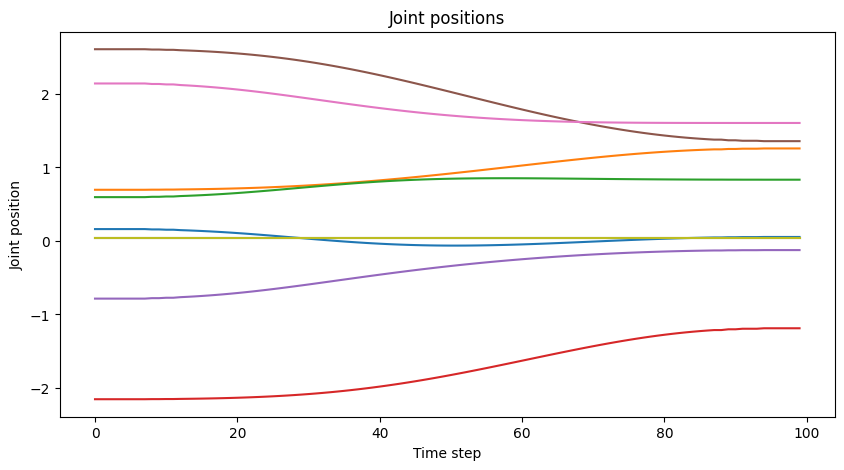

In [135]:
# plot joint positions
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(qs)
plt.title('Joint positions')
plt.xlabel('Time step')
plt.ylabel('Joint position')
plt.show()

In [136]:
qs = np.array(qs)
for q in qs:
    franka.control_dofs_force(np.array([-15, -15]), fingers_dof)
    #franka.control_dofs_position(np.array([0.02, 0.02]), fingers_dof)
    franka.control_dofs_position(q[:-2], motors_dof)
    #franka.set_qpos(q[:-2], motors_dof)

    scene.step()   

[Genesis] [21:53:08] [INFO] Running at 1.91 FPS.
[Genesis] [21:53:08] [INFO] Running at 2.00 FPS.
[Genesis] [21:53:08] [INFO] Running at 2.08 FPS.
[Genesis] [21:53:08] [INFO] Running at 2.18 FPS.
[Genesis] [21:53:08] [INFO] Running at 2.27 FPS.
[Genesis] [21:53:08] [INFO] Running at 2.38 FPS.
[Genesis] [21:53:09] [INFO] Running at 2.49 FPS.
[Genesis] [21:53:09] [INFO] Running at 2.60 FPS.
[Genesis] [21:53:09] [INFO] Running at 2.72 FPS.
[Genesis] [21:53:09] [INFO] Running at 2.83 FPS.
[Genesis] [21:53:09] [INFO] Running at 2.94 FPS.
[Genesis] [21:53:09] [INFO] Running at 3.07 FPS.
[Genesis] [21:53:09] [INFO] Running at 3.18 FPS.
[Genesis] [21:53:09] [INFO] Running at 3.31 FPS.
[Genesis] [21:53:09] [INFO] Running at 3.45 FPS.
[Genesis] [21:53:09] [INFO] Running at 3.60 FPS.
[Genesis] [21:53:09] [INFO] Running at 3.74 FPS.
[Genesis] [21:53:09] [INFO] Running at 3.88 FPS.
[Genesis] [21:53:09] [INFO] Running at 4.03 FPS.
[Genesis] [21:53:09] [INFO] Running at 4.17 FPS.
[Genesis] [21:53:10]

In [15]:
# calling functions for cube_sclerp
scene.reset()
s, q, h = get_obj_screw(cube)
cube_initial_dq, Cube_goal_dq = obj_dq(cube)
dq_traj, obj_qpos = obj_sclerp(cube, cube_initial_dq, Cube_goal_dq, 'linear', 100)
dq_traj.shape

[Genesis] [19:48:56] [INFO] Resetting Scene <a41d145>.


(100, 8)

In [22]:
qs[99]

tensor([ 5.2684e-05,  1.5579e+00, -2.6884e-04, -4.4058e-01,  3.8817e-06,
         4.1185e-01,  7.8515e-01,  2.2496e-02,  7.1187e-03])

In [27]:
franka.set_qpos(qs[80][:-2], motors_dof)
scene.step()

[Genesis] [19:50:57] [INFO] Running at 0.21 FPS.


In [16]:
# cube sclerp motion
scene.reset()
for i in range (obj_qpos.shape[0]):
    franka.set_qpos(qr)
    cube.set_qpos(obj_qpos[i])
    scene.step()

[Genesis] [19:49:00] [INFO] Resetting Scene <a41d145>.
[Genesis] [19:49:00] [INFO] Running at 0.46 FPS.
[Genesis] [19:49:00] [INFO] Running at 0.49 FPS.
[Genesis] [19:49:00] [INFO] Running at 0.51 FPS.
[Genesis] [19:49:00] [INFO] Running at 0.54 FPS.
[Genesis] [19:49:00] [INFO] Running at 0.57 FPS.
[Genesis] [19:49:00] [INFO] Running at 0.60 FPS.
[Genesis] [19:49:00] [INFO] Running at 0.63 FPS.
[Genesis] [19:49:00] [INFO] Running at 0.66 FPS.
[Genesis] [19:49:00] [INFO] Running at 0.69 FPS.
[Genesis] [19:49:00] [INFO] Running at 0.73 FPS.
[Genesis] [19:49:00] [INFO] Running at 0.77 FPS.
[Genesis] [19:49:00] [INFO] Running at 0.81 FPS.
[Genesis] [19:49:00] [INFO] Running at 0.85 FPS.
[Genesis] [19:49:00] [INFO] Running at 0.89 FPS.
[Genesis] [19:49:00] [INFO] Running at 0.94 FPS.
[Genesis] [19:49:00] [INFO] Running at 0.99 FPS.
[Genesis] [19:49:00] [INFO] Running at 1.04 FPS.
[Genesis] [19:49:00] [INFO] Running at 1.09 FPS.
[Genesis] [19:49:00] [INFO] Running at 1.15 FPS.
[Genesis] [19:

In [22]:
# calling functions for cylinder_sclerp
scene.reset()
s, q, h = get_obj_screw(cylinder)
cyl_initial_dq, cyl_goal_dq = obj_dq(cylinder)
dq_traj, obj_qpos = obj_sclerp(cylinder, cyl_initial_dq, cyl_goal_dq, 'linear', 100)
dq_traj.shape

[Genesis] [17:52:28] [INFO] Resetting Scene <2580b40>.


(100, 8)

In [ ]:
# cylinder sclerp motion
scene.reset()
for i in range (obj_qpos.shape[0]):
    franka.set_qpos(qr)
    cylinder.set_qpos(obj_qpos[i])
    scene.step()

[Genesis] [17:51:21] [INFO] Resetting Scene <2580b40>.
[Genesis] [17:51:22] [INFO] Running at 0.87 FPS.
[Genesis] [17:51:22] [INFO] Running at 0.92 FPS.
[Genesis] [17:51:22] [INFO] Running at 0.97 FPS.
[Genesis] [17:51:22] [INFO] Running at 1.02 FPS.
[Genesis] [17:51:22] [INFO] Running at 1.07 FPS.
[Genesis] [17:51:22] [INFO] Running at 1.12 FPS.
[Genesis] [17:51:22] [INFO] Running at 1.18 FPS.
[Genesis] [17:51:22] [INFO] Running at 1.24 FPS.
[Genesis] [17:51:22] [INFO] Running at 1.30 FPS.
[Genesis] [17:51:22] [INFO] Running at 1.36 FPS.
[Genesis] [17:51:22] [INFO] Running at 1.43 FPS.
[Genesis] [17:51:22] [INFO] Running at 1.50 FPS.
[Genesis] [17:51:22] [INFO] Running at 1.58 FPS.
[Genesis] [17:51:22] [INFO] Running at 1.66 FPS.
[Genesis] [17:51:22] [INFO] Running at 1.74 FPS.
[Genesis] [17:51:22] [INFO] Running at 1.83 FPS.
[Genesis] [17:51:22] [INFO] Running at 1.92 FPS.
[Genesis] [17:51:22] [INFO] Running at 2.02 FPS.
[Genesis] [17:51:22] [INFO] Running at 2.12 FPS.
[Genesis] [17:

In [ ]:

# get the end-effector link
end_effector = franka.get_link('hand')
above_box = cube.get_pos().cpu().numpy() + np.array([-cube_size[0]/2 + 0.02, 0, 0.11 + 0.1])
# move to pre-grasp pose
qpos = franka.inverse_kinematics(
    link = end_effector,
    pos  = above_box,
    quat = np.array([0, 1, 0, 0]),
)
# # gripper open pos
# qpos[-2:] = 0.04
# path = franka.plan_path(
#     qpos_goal     = qpos,
#     num_waypoints = 200, # 2s duration
# )

In [ ]:
franka.get_qpos(), qpos

# find straight path in joint space
s = np.linspace(0, 1, 200)
current_pose = franka.get_qpos().cpu().numpy()
goal_pos = qpos.cpu().numpy()
path = current_pose + s[:, None] * (goal_pos - current_pose)


In [ ]:
for qpos in path:
    # set qpos
    franka.control_dofs_position(qpos)
    # step simulation
    scene.step()

In [ ]:
qpos

In [ ]:
# # execute the planned path
# for waypoint in path:
#     franka.control_dofs_position(waypoint)
#     scene.step()

# allow robot to reach the last waypoint
for i in range(100):
    scene.step()


In [ ]:
side_box = above_box + np.array([0.0, 0.0, -0.1])


# reach
qpos_reach = franka.inverse_kinematics(
    link = end_effector,
    pos  = side_box,
    quat = np.array([0, 1, 0, 0]),
)
# path = franka.plan_path(
#     qpos_goal     = qpos_reach,
#     num_waypoints = 100, # 1s duration
# )

# for waypoint in path:
franka.control_dofs_position(qpos_reach)
    # scene.step()

# allow robot to reach the last waypoint
for i in range(100):
    scene.step()

In [ ]:



# grasp
franka.control_dofs_position(qpos_reach[:-2], motors_dof)
franka.control_dofs_force(np.array([-0.5, -0.5]), fingers_dof)

for i in range(100):
    scene.step()


In [ ]:

# lift
qpos = franka.inverse_kinematics(
    link=end_effector,
    pos=np.array([0.65, 0.0, 0.28]),
    quat=np.array([0, 1, 0, 0]),
)
franka.control_dofs_position(qpos[:-2], motors_dof)
for i in range(200):
    scene.step()

In [ ]:
# open
qpos = franka.inverse_kinematics(
    link=end_effector,
    pos=np.array([0.65, 0.0, 0.28]),
    quat=np.array([0, 1, 0, 0]),
)

franka.control_dofs_position(qpos[:-2], motors_dof)
franka.control_dofs_force(np.array([0, 0]), fingers_dof)
for i in range(100):
    scene.step()
# allow robot to reach the last waypoint
for i in range(100):
    scene.step()

In [ ]:
franka.get_dofs_force()

In [ ]:
cube_pos = cube.get_pos().cpu().numpy()
cube_quat = cube.get_quat().cpu().numpy()

cube_pos, cube_quat

In [ ]:
cube_pos = cube.get_pos().cpu().numpy()
cube_quat = cube.get_quat().cpu().numpy()

qpos = franka.inverse_kinematics(
    link=end_effector,
    pos=cube_pos + np.array([0, 0, 0.3]),
    quat=np.array([0, 1, 0, 0]),
)

franka.control_dofs_position(qpos[:-2], motors_dof)
franka.control_dofs_force(np.array([0, 0]), fingers_dof)
for i in range(100):
    scene.step()
# allow robot to reach the last waypoint
for i in range(100):
    scene.step()

In [ ]:

cam.start_recording()
import numpy as np

for i in range(120):
    scene.step()
    cam.set_pose(
        pos    = (3.0 * np.sin(i / 60), 3.0 * np.cos(i / 60), 2.5),
        lookat = (0, 0, 0.5),
    )
    cam.render()
cam.stop_recording(save_to_filename='video.mp4', fps=60)